# Series Expansions: Fourier

Series expansions are used in a variety of circumstances:
- When we need a tractable approximation to some ugly equation
- To transform between equivalent ways of looking at a problem (e.g. time domain vs frequency domain)
- When they are (part of) a solution to a particular class of differential equation

For approximations, there is an important divide between getting the best fit *near a point* (e.g. Taylor series) and getting the best fit *over an interval* (e.g. Fourier series). This notebook deals with the latter; there is a separate notebook for Taylor expansions, and others for Bessel, Legendre, etc.

## Fitting over an interval

What is the best (tractable) series approximating my function across some range of values? What matters is an overall best fit (e.g. least-squares deviation) across the range, and we can't tolerate wild divergences as with the Taylor series.

There are various series which are useful in different contexts, but a common property is that the terms are *orthogonal* over some interval $[-L,L]$. If $f(t)$ is a real-valued function their *inner product* is defined as

$$ \langle f(m t),f(n t) \rangle   \colon =\int _{-L}^L f(m t) f(n t) \,  dt $$

For orthogonal functions, this is non-zero if $m=n$ and zero if $m \ne n$. If the inner product is $\delta_{mn}$ (the Kronecker delta), the fuctions are said to be orthonormal.

# Differential Equations

The ODE $y'' + n^2 y = 0$ is solved by all the period functions $\sin(n x)$, $\cos(n x)$ and $e^{\pm i n x}$. There is thus a close analogy to functions such as Bessel and Legendre, though sine and cosine have become much more familar to most of us for other (geometric) reasons. They have the nice property of evenly-spaced zeros, unlike Bessel functions. For example, $\sin(x)=0$ for $x = n \pi$ where n is any integer.

The use of sin/cos or complex exponentials is also exceptionally familiar in series expansions, mainly because they are so useful in engineering and communications.

## Fourier Series and Fourier Analysis

A periodic function $f$ of period $2L$ can be approximated by a Fourier Series of sines and cosines:

$$ f(t) = \frac{a_0}{2} + \sum _{n \ge 1} a_ n \cos \frac{n \pi t}{L} + \sum _{n \ge 1} b_ n \sin \frac{n \pi t}{L}  $$

To find the coefficients:
$$
\begin{align*}
	\frac{a_0}{2} &= \displaystyle \frac{1}{2L} \int _{-L}^{L} f(t) \,  dt = \frac{\langle f(t), 1 \rangle }{\langle 1, 1\rangle }\\[6pt]
	a_ n& = \frac{1}{L} \int _{-L}^{L} f(t) \cos \frac{n \pi t}{L} \,  dt = \frac{\langle f(t),\cos \left(\frac{n \pi }{L} t\right)\rangle }{\langle \cos \left(\frac{n \pi }{L} t\right), \cos \left(\frac{n \pi }{L} t\right)\rangle } \\[10pt]
	b_ n &= \displaystyle \frac{1}{L} \int _{-L}^{L} f(t) \sin \frac{n \pi t}{L} \,  dt = \frac{\langle f(t),\sin \left(\frac{n \pi }{L} t\right)\rangle }{\langle \sin \left(\frac{n \pi }{L} t\right), \sin \left(\frac{n \pi }{L} t\right)\rangle }
\end{align*}
$$

Equivalently, we can express the Fourier Series as complex exponentials:

$$ f\left(t\right) = \sum _{n = -\infty }^{\infty } c_{n} e^{i n t}, \qquad c_{n} \colon =\frac{a_{n} - i b_{n}}{2} \quad \text{ and } \quad c_{-n} \colon =\bar{c}_{n} = \frac{a_{n} + i b_{n}}{2} $$

Real-world situations tend not to give infinitely periodic functions, so Fourier Analysis can be thought of as the limit as $L$ goes to infinity of a periodic signal of period $2L$. As $L$ increases, the spacing between the frequencies in our sum are approaching zero. This turns the sum into an integral in the limit, and we have the equations:
 
$$ f(t)  = \int _{-\infty }^{\infty } \widehat{f}\left(k\right)e^{ i k t} \,  dk  \quad \text{where} \quad \widehat{f} = \frac{1}{2\pi }\int _{-\infty }^{\infty } f\left(t\right)e^{- i k t} \,  dt $$

We call $\widehat{f}$ the **Fourier transform** of $f(t)$.

Start with quite a lot of imports ready for calculation and plotting:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as w

plt.rcParams.update({'font.size': 16})

from sympy import fourier_series, pi, init_printing, lambdify, integrate
init_printing()
from sympy.functions import sin, cos
from sympy.abc import x

from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import standard_transformations, implicit_multiplication_application
transformations = (standard_transformations + (implicit_multiplication_application,))

SymPy has a FourierSeries class which looked like it would do what we need, very simply. The results were disappointing: `fourier_series()` returns a very complicated result for even simple functions, and attempts to lambdify this never terminated.

The `fourier_coeff()` function below calculates $a_n$ and $b_n$ by integration and returns them as NumPy arrays to 5 figure accuracy. Note that this is only for illustrating the effect of adding more terms: the calculation is slow and clunky, and nobody would do Fourier transforms this way for real problems.

In [2]:
# Fourier series, to order n
def fourier_coeff(f, L, n):
    # f is a SymPy function of x
    a_n = []
    b_n = [0,]
    a_n.append((1/(2*L)*integrate(f, (x, -L, L))).evalf(5))
    for i in range(1, n+1):
        a_n.append((1/L*integrate(f*cos(i*pi/L*x), (x, -L, L))).evalf(5))
        b_n.append((1/L*integrate(f*sin(i*pi/L*x), (x, -L, L))).evalf(5))
        
    # SymPy is VERY reluctant to give us simple numbers rather than SymPy objects
    # Force the conversion to NumPy floats with np.array().astype()
    return (np.array(a_n).astype(np.float64), np.array(b_n).astype(np.float64))

In [3]:
# Plot results
def plotFourier(f_sympy, L):
    
    max_terms = 20
    
    # get a NumPy-style function from the SymPy version
    f_np = lambdify(x, f_sympy, 'numpy')
    display(f_sympy) # display shows LaTex, print wouldn't
    
    # plot the starting function
    x_lims = [-L,L]
    x1 = np.linspace(x_lims[0], x_lims[1], 100)
    fig = plt.figure(figsize=(9, 20))
    
    ax1 = fig.add_subplot(311)
    ax1.plot(x1, f_np(x1), 'k.', label=f_sympy)
        
    # get some terms of a Fourier series 
#     f_fourier = fourier_series(f_sympy, (x, -L, L))
#     f_fourier.truncate(4)
#     display(f_fourier)

    a_n, b_n = fourier_coeff(f_sympy, L, max_terms)
    
    ax2 = fig.add_subplot(312)
    x_int = range(0, len(a_n))
#     ax2.stem(a_n, 'k.', label='a_n')
    ax2.stem(x_int, a_n, markerfmt='C0o', label='a_n')
    ax2.stem(x_int, b_n, markerfmt='C1o', label='b_n')
    ax2.set_xlim(left=-0.5)
    ax2.set_ylabel('coefficients')
#     ax2.xaxis.set_major_locator(MaxNLocator(integer=True)) # fails
    ax2.legend()
    
    # plot the successive approximations
    for n in [0,1,2,3,5,10,20]:
        if n > max_terms:
            break
        y = np.zeros(len(x1))
        for i in range(n+1):
            cos_term = a_n[i]*np.cos(i*np.pi/L*x1)
            sin_term = b_n[i]*np.sin(i*np.pi/L*x1)
            y += (cos_term + sin_term)
        ax1.plot(x1, y, label='order ' + str(n))

    # graph housekeeping
    ax1.set_xlim(x_lims)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend()
    ax1.grid(True)
    plt.title('Fourier series approximation of ' + str(f_sympy))

In [4]:
def parse_input(f_txt, L):
    f_sympy = parse_expr(f_txt, transformations=transformations)
    plotFourier(f_sympy, L)

Please wait patiently for each new calculation, which will take several seconds at best.

In [5]:
style = {'description_width': 'initial'} # to avoid the labels getting truncated
interact(parse_input, 
             f_txt = w.Text(description='f(x):',
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            value='x**2 - x**3'),
             L = w.FloatSlider(description="Limits $\pm L$", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            min=1, max=10, 
                                            value=np.pi),
);

interactive(children=(Text(value='x**2 - x**3', continuous_update=False, description='f(x):', layout=Layout(wi…

### Discrete Fourier transforms

The mathematics of Fourier analysis goes back to the early 19th century, but its use has exploded in the last few decades. A couple of factors collided to drive this:

- An efficient Fast Fourier Transform (FFT) algorithm, developed in the 1960s and implemented in both software and specialist hardware
- The spread of digital technology, for audio, video and many other sorts of discretized signals. These are all perfect inputs for FFT.

FFT gets away from complicated integrals and replaces them with a series of simple multiplications and additions. This gives a computation time of $\mathcal{O}(N \log N)$ for a signal with $N$ data points. Fast, as the name suggests! And your cellphone is doing millions of these calculations whenever you use it (for anything at all).

There are many FFT functions in the `numpy.fft` module, but for real input we will use the `rfft()` function and its inverse, `irfft()`. This avoids calculating and storing half the coefficients, which for real input are just complex conjugates of the other half.

Zeroing all but the first few coefficients before the inverse FFT simulates the effect of using few terms in the Fourier series.

In [6]:
def plotFFT(f_sympy, L):
    
    n_pts = 100
    
    # get a NumPy-style function from the SymPy version
    f_np = lambdify(x, f_sympy, 'numpy')
    
    # discretize the function (for fft, not just for plotting)
    x_lims = [-L,L]
    x1 = np.linspace(x_lims[0], x_lims[1], n_pts)
    y = f_np(x1)
    
    # plot the starting function
    fig = plt.figure(figsize=(9, 20))
    ax1 = fig.add_subplot(311)
    ax1.plot(x1, f_np(x1), 'k.', label=f_sympy)
    
    display(f_sympy) # display shows LaTex, print wouldn't
    
    f_fft = np.fft.rfft(y)

    # get a_n and b_n from complex coefficients in f_fft
#     print(f_fft.shape)
#     print(f_fft)
    a_n = np.real(f_fft[:50] + np.conj(f_fft[:50]))
    a_n[0] = a_n[0]/2
    b_n = np.imag(f_fft[:50] - np.conj(f_fft[:50]))
    
    ax2 = fig.add_subplot(312)
    x_int = range(0, len(a_n))
    ax2.stem(x_int, a_n, markerfmt='C0o', label='real')
    ax2.stem(x_int, b_n, markerfmt='C1o', label='imag')
#     ax2.set_xlim(left=-0.5)
    ax2.set_ylabel('coefficients')
#     ax2.xaxis.set_major_locator(MaxNLocator(integer=True)) # fails
    ax2.legend()

#     # plot the successive approximations - FAILS
    for i in [0,1,2,3,10,20]:
        fft_i = np.zeros(len(f_fft), dtype=np.cfloat)
        np.put(fft_i, range(i+1), f_fft[:i+1])
        y_i = np.real(np.fft.irfft(fft_i))
        ax1.plot(x1, y_i, label='order ' + str(i))
    
    y_i = np.real(np.fft.irfft(f_fft))
    ax1.plot(x1, y_i, label='full inverse FFT')
    
    # graph housekeeping
    ax1.set_xlim(x_lims)
#     plt.ylim([-3,3])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend()
    ax1.grid(True)
    plt.title('FFT series approximation of ' + str(f_sympy))

In [7]:
def parse_input_fft(f_txt, L):
    # we could just run eval(f_txt), 
    # but parse_expr() followed by lambdify() is probably safer
    f_sympy = parse_expr(f_txt, transformations=transformations)
    plotFFT(f_sympy, L)

In [8]:
style = {'description_width': 'initial'} # to avoid the labels getting truncated
interact(parse_input_fft, 
             f_txt = w.Text(description='f(x):',
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            value='x**2 - x**3'),
             L = w.FloatSlider(description="Limits $\pm L$", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            min=1, max=10, 
                                            value=np.pi),
        );

interactive(children=(Text(value='x**2 - x**3', continuous_update=False, description='f(x):', layout=Layout(wi…

In [9]:
def plotFFT_discontinuous(waveform='square', L=np.pi):
    
    n_pts = 100
    
    # discretize the function (for fft, not just for plotting)
    x_lims = [-L,L]
    x1 = np.linspace(x_lims[0], x_lims[1], n_pts)
    
    if waveform == 'square':
        y = np.sign(x1)
    elif waveform=='triangle':
        y = np.abs(x1)
    
    # plot the starting function
    fig = plt.figure(figsize=(9, 20))
    ax1 = fig.add_subplot(311)
    ax1.plot(x1, y, 'r.', label=waveform)
    
    f_fft = np.fft.rfft(y)

    # get a_n and b_n from complex coefficients in f_fft
#     print(f_fft.shape)
#     print(f_fft)
    a_n = np.real(f_fft[:50] + np.conj(f_fft[:50]))
    a_n[0] = a_n[0]/2
    b_n = np.imag(f_fft[:50] - np.conj(f_fft[:50]))
    
    ax2 = fig.add_subplot(312)
    x_int = range(0, len(a_n))
    ax2.stem(x_int, a_n, markerfmt='C0o', label='a_n')
    ax2.stem(x_int, b_n, markerfmt='C1o', label='b_n')
#     ax2.set_xlim(left=-0.5)
    ax2.set_ylabel('coefficients')
#     ax2.xaxis.set_major_locator(MaxNLocator(integer=True)) # fails
    ax2.legend()

    y_i = np.real(np.fft.irfft(f_fft))
    ax1.plot(x1, y_i, label='full inverse FFT')
    
    # graph housekeeping
    ax1.set_xlim(x_lims)
#     plt.ylim([-3,3])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend()
    ax1.grid(True)
    plt.title('FFT approximation of ' + waveform + ' wave')

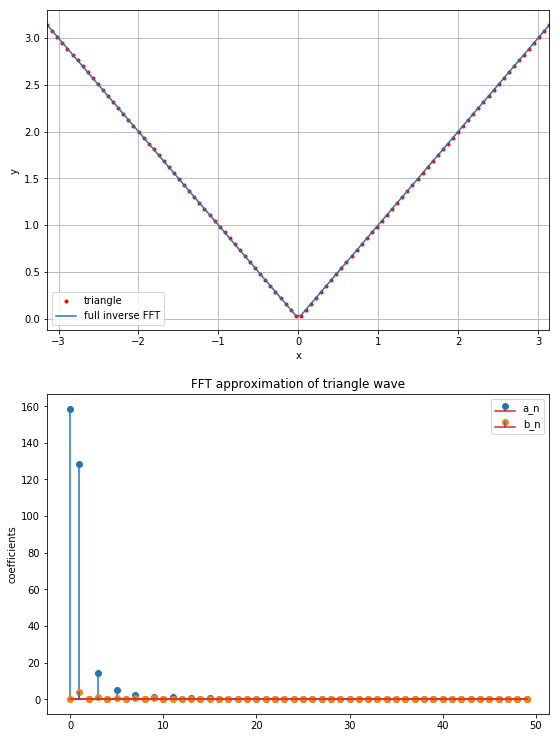

In [10]:
plotFFT_discontinuous('triangle')

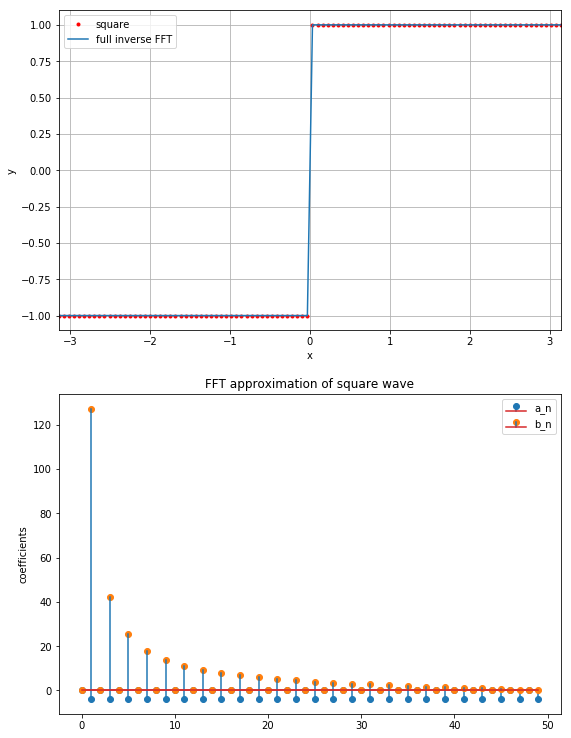

In [11]:
plotFFT_discontinuous('square')

<a id='refs'></a>

## References

Boas, "Mathematical methods in the physical sciences"